Harsh Karia <br>
GitHub Username: harshkaria<br>
USC ID: 5860082592

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.preprocessing import OrdinalEncoder
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import OneHotEncoder
from gap_statistic import OptimalK
from IPython.display import IFrame

In [8]:
def svm_classifier_with_loss(penalty=None, gamma=None):
    exact_scores_loss = []
    hamming_loss_array = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x_train):
        x_data = x_train.iloc[train_index]
        y_data = y_train.iloc[train_index]
        x_data_test = x_train.iloc[test_index]
        y_data_test = y_train.iloc[test_index]
        model = SVC(kernel='rbf', C=penalty, gamma=gamma)
        ovr = OneVsRestClassifier(model)
        multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
        multilabel_classifier.fit(x_data, y_data)
        y_pred = multilabel_classifier.predict(x_data_test)
        exact_match_ratio_loss = 1 - np.all(y_pred == y_data_test, axis=1).mean()
        exact_scores_loss.append(exact_match_ratio_loss)
        hamming_loss_score = np.sum(np.not_equal(y_data_test, y_pred))/float(y_data_test.size)
        hamming_loss_array.append(np.sum(hamming_loss_score))
    return {'exact_score_loss': np.mean(exact_scores_loss), 'hamming_loss': np.mean(hamming_loss_array)}

In [18]:
def svm_classifier_with_loss_l1(c):
    exact_scores_loss = []
    hamming_loss_array = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x_train):
        x_data = x_train.iloc[train_index]
        y_data = y_train.iloc[train_index]
        x_data_test = x_train.iloc[test_index]
        y_data_test = y_train.iloc[test_index]
        model = LinearSVC(penalty='l1', C=c, dual=False)
        ovr = OneVsRestClassifier(model)
        multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
        steps = [('scaler', StandardScaler()), ('model',multilabel_classifier)] 
        pipeline = Pipeline(steps)
        pipeline.fit(x_data, y_data)
        y_pred = pipeline.predict(x_data_test)
        exact_match_ratio_loss = 1 - np.all(y_pred == y_data_test, axis=1).mean()
        exact_scores_loss.append(exact_match_ratio_loss)
        hamming_loss_score = np.sum(np.not_equal(y_data_test, y_pred))/float(y_data_test.size)
        hamming_loss_array.append(np.sum(hamming_loss_score))
    return {'exact_score_loss': np.mean(exact_scores_loss), 'hamming_loss': np.mean(hamming_loss_array)}

In [27]:
def svm_classifier_with_loss_l1_smote(c):
    exact_scores_loss = []
    hamming_loss_array = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x_train):
        x_data = x_train.iloc[train_index]
        y_data = y_train.iloc[train_index]
        x_data_test = x_train.iloc[test_index]
        y_data_test = y_train.iloc[test_index]
        fam_data_train = y_data['Family_code']
        fam_data_test = y_data_test['Family_code']
        gen_data_train = y_data['Genus_code']
        gen_data_test = y_data_test['Genus_code']
        spe_data_train = y_data['Species_code']
        spe_data_test = y_data_test['Species_code']
        model = LinearSVC(penalty='l1', C=c, dual=False)
        steps = [('scaler', StandardScaler()), ('model', model)]
        pipeline_fam = Pipeline(steps)
        pipeline_gen = Pipeline(steps)
        pipeline_spe = Pipeline(steps)
        os = SMOTE(random_state=0)
        os_data_x, os_data_y= os.fit_resample(x_data, fam_data_train)
        pipeline_fam.fit(os_data_x, os_data_y)
        os_data_x, os_data_y= os.fit_resample(x_data, gen_data_train)
        pipeline_gen.fit(os_data_x, os_data_y)
        os_data_x, os_data_y= os.fit_resample(x_data, spe_data_train)
        pipeline_spe.fit(os_data_x, os_data_y)
        y_pred_fam = pd.Series(pipeline_fam.predict(x_data_test))
        y_pred_gen = pd.Series(pipeline_gen.predict(x_data_test))
        y_pred_spe = pd.Series(pipeline_spe.predict(x_data_test))
        frame = { 'Family_code': y_pred_fam, 'Genus_code': y_pred_gen, 'Species_code':  y_pred_spe}
        y_pred = pd.DataFrame(frame)
        exact_match_ratio_loss = 1 - np.all(y_pred.reset_index(drop=True) == y_data_test.reset_index(drop=True), axis=1).mean()
        exact_scores_loss.append(exact_match_ratio_loss)
        hamming_loss_score = np.sum(np.not_equal(y_data_test.reset_index(drop=True), y_pred.reset_index(drop=True)))/float(y_data_test.size)
        hamming_loss_array.append(np.sum(hamming_loss_score))
    return {'exact_score_loss': np.mean(exact_scores_loss), 'hamming_loss': np.mean(hamming_loss_array)}

---
### Data

In [2]:
data = pd.read_csv('../data/Frogs_MFCCs.csv')
data

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber,60


In [3]:
enc = OrdinalEncoder()
data["Family_code"] = enc.fit_transform(all_data[["Family"]])
data["Genus_code"] = enc.fit_transform(all_data[["Genus"]])
data["Species_code"] = enc.fit_transform(all_data[["Species"]])

In [4]:
train_data, test_data = train_test_split(data, test_size=0.3)

#### 1. Multi-class and Multi-Label Classification Using Support Vector Machines

#### 1. b) i. Exact Match and Hamming Score Methood 

### *** Reference: https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

The Exact Match and Hamming Score metrics are generally used to evaluate the performance of a multi-label classifier.

#### Exact Match Method

We increase the metric score by `1/n` (where n is the number of samples) when and iff all the labels of a classification are correct. 

#### Hamming Loss/Score Method

Hamming Loss is the fraction of the wrong labels to the total number of labels. It reports how many times on average the relevance of an example to a class label is incorrectly predicted.

#### 1. b) ii.

In [7]:
x_train = train_data.drop(['Family', 'Genus', 'Species', 'RecordID', 'Family_code', 'Genus_code', 'Species_code'], axis=1)
x_test = test_data.drop(['Family', 'Genus', 'Species', 'RecordID', 'Family_code', 'Genus_code', 'Species_code'], axis=1)
y_train = train_data[['Family_code', 'Genus_code', 'Species_code']]
y_test = test_data[['Family_code', 'Genus_code', 'Species_code']]

In [9]:
penalties = np.linspace(0.001, 100, 20)
gammas = np.linspace(0.1, 2.0, num=20)
exact_scores = []
hamming_scores = []
for penalty in penalties:
    for gamma in gammas:
        temp = svm_classifier_with_loss(penalty, gamma)
        exact_scores.append({
            'score': temp['exact_score_loss'],
            'penalty': penalty,
            'gamma': gamma
        })
        hamming_scores.append({
            'score': temp['hamming_loss'],
            'penalty': penalty,
            'gamma': gamma
        })

In [10]:
penalty_scores_exact = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, exact_scores))
    try:
        penalty_scores_exact.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_exact.append(1)
        
gamma_scores_exact = []
for gamma in gammas:
    temp = list(filter(lambda x: x['gamma']==gamma, exact_scores))
    try:
        gamma_scores_exact.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        gamma_scores_exact.append(1)
        
penalty_scores_ham = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, hamming_scores))
    try:
        penalty_scores_ham.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_ham.append(1)
        
gamma_scores_ham = []
for gamma in gammas:
    temp = list(filter(lambda x: x['gamma']==gamma, hamming_scores))
    try:
        gamma_scores_ham.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        gamma_scores_ham.append(1)

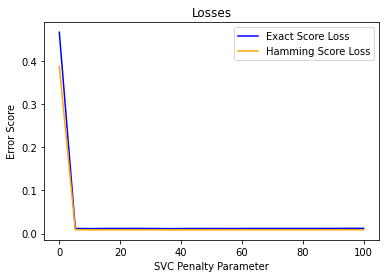

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot(penalties, penalty_scores_exact, 'blue', label='Exact Score Loss')
ax.plot(penalties, penalty_scores_ham, 'orange', label='Hamming Score Loss')

ax.set_ylabel('Error Score')
ax.set_xlabel('SVC Penalty Parameter')
ax.set_title('Losses')
ax.legend()

plt.show()

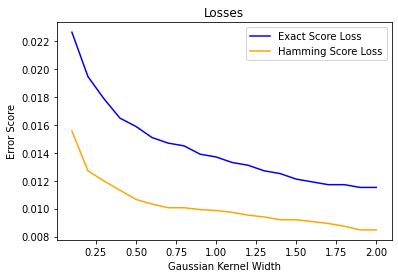

In [12]:
fig = plt.figure()
ax = plt.axes()
ax.plot(gammas, gamma_scores_exact, 'blue', label='Exact Score Loss')
ax.plot(gammas, gamma_scores_ham, 'orange', label='Hamming Score Loss')

ax.set_ylabel('Error Score')
ax.set_xlabel('Gaussian Kernel Width')
ax.set_title('Losses')
ax.legend()

plt.show()

In [13]:
best_exact_match = min(exact_scores, key = lambda x: x['score'])

In [14]:
best_hamming = min(hamming_scores, key = lambda x: x['score'])

In [15]:
model = SVC(kernel='rbf', C=best_exact_match['penalty'], gamma=best_exact_match['gamma'])
ovr = OneVsRestClassifier(model)
multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
multilabel_classifier.fit(x_train, y_train)
y_pred = multilabel_classifier.predict(x_test)
exact_match_ratio_test = 1 - np.all(y_pred == y_test, axis=1).mean()

In [16]:
model = SVC(kernel='rbf', C=best_hamming['penalty'], gamma=best_hamming['gamma'])
ovr = OneVsRestClassifier(model)
multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
multilabel_classifier.fit(x_train, y_train)
y_pred = multilabel_classifier.predict(x_test)
hamming_loss_test = np.sum(np.not_equal(y_test, y_pred))/float(y_test.size)

In [17]:
summary_data = {
                'Loss Type':  ['Exact Match', 'Hamming Loss'],
                'Penalty': [best_exact_match['penalty'], best_hamming['penalty']],
                'Gaussian Kernel Width': [best_exact_match['gamma'], best_hamming['gamma']],
                'Error': [exact_match_ratio_test, np.mean(hamming_loss_test)]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Loss Type')

,Penalty,Gaussian Kernel Width,Error
Loss Type,,,
Exact Match,10.527211,1.9,0.013432
Hamming Loss,10.527211,1.9,0.003242


#### 1. b) iii.

In [19]:
penalties = np.linspace(0.001, 100, 20)
exact_scores = []
hamming_scores = []
for penalty in penalties:
    temp = svm_classifier_with_loss_l1(penalty)
    exact_scores.append({
        'score': temp['exact_score_loss'],
        'penalty': penalty
    })
    hamming_scores.append({
        'score': temp['hamming_loss'],
        'penalty': penalty
    })

In [20]:
penalty_scores_exact = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, exact_scores))
    try:
        penalty_scores_exact.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_exact.append(1)
        
penalty_scores_ham = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, hamming_scores))
    try:
        penalty_scores_ham.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_ham.append(1)

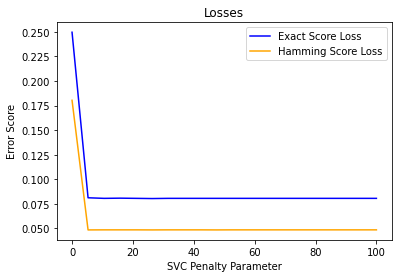

In [21]:
fig = plt.figure()
ax = plt.axes()
ax.plot(penalties, penalty_scores_exact, 'blue', label='Exact Score Loss')
ax.plot(penalties, penalty_scores_ham, 'orange', label='Hamming Score Loss')

ax.set_ylabel('Error Score')
ax.set_xlabel('SVC Penalty Parameter')
ax.set_title('Losses')
ax.legend()

plt.show()

In [22]:
best_exact_match = min(exact_scores, key = lambda x: x['score'])

In [23]:
best_hamming = min(hamming_scores, key = lambda x: x['score'])

In [24]:
model = LinearSVC(penalty='l1', C=best_exact_match['penalty'], dual=False)
ovr = OneVsRestClassifier(model)
multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
steps = [('scaler', StandardScaler()), ('model',multilabel_classifier)] 
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
exact_match_ratio_test = 1 - np.all(y_pred == y_test, axis=1).mean()

In [25]:
model = LinearSVC(penalty='l1', C=best_hamming['penalty'], dual=False)
ovr = OneVsRestClassifier(model)
multilabel_classifier = MultiOutputClassifier(ovr, n_jobs=-1)
steps = [('scaler', StandardScaler()), ('model',multilabel_classifier)] 
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
hamming_loss_test = np.sum(np.not_equal(y_test, y_pred))/float(y_test.size)

In [26]:
summary_data = {
                'Loss Type':  ['Exact Match', 'Hamming Loss'],
                'Penalty': [best_exact_match['penalty'], best_hamming['penalty']],
                'Error': [exact_match_ratio_test, np.mean(hamming_loss_test)]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Loss Type')

,Penalty,Error
Loss Type,,
Exact Match,26.316526,0.093099
Hamming Loss,5.264105,0.019145


#### 1. b) iv.

In [28]:
penalties = np.linspace(0.001, 100, 20)
exact_scores = []
hamming_scores = []
for penalty in penalties:
    temp = svm_classifier_with_loss_l1_smote(penalty)
    exact_scores.append({
        'score': temp['exact_score_loss'],
        'penalty': penalty
    })
    hamming_scores.append({
        'score': temp['hamming_loss'],
        'penalty': penalty
    })

In [29]:
penalty_scores_exact = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, exact_scores))
    try:
        penalty_scores_exact.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_exact.append(1)
        
penalty_scores_ham = []
for penalty in penalties:
    temp = list(filter(lambda x: x['penalty']==penalty, hamming_scores))
    try:
        penalty_scores_ham.append(min(temp, key = lambda x: x['score'])['score'])
    except:
        penalty_scores_ham.append(1)

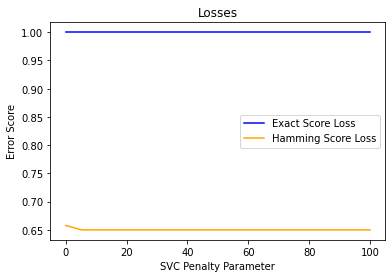

In [30]:
fig = plt.figure()
ax = plt.axes()
ax.plot(penalties, penalty_scores_exact, 'blue', label='Exact Score Loss')
ax.plot(penalties, penalty_scores_ham, 'orange', label='Hamming Score Loss')

ax.set_ylabel('Error Score')
ax.set_xlabel('SVC Penalty Parameter')
ax.set_title('Losses')
ax.legend()

plt.show()

In [31]:
best_exact_match = min(exact_scores, key = lambda x: x['score'])

In [32]:
best_hamming = min(hamming_scores, key = lambda x: x['score'])

In [33]:
model = LinearSVC(penalty='l1', C=best_exact_match['penalty'], dual=False)
steps = [('scaler', StandardScaler()), ('model',model)] 
fam_data_train = y_train['Family_code']
fam_data_test = y_test['Family_code']
gen_data_train = y_train['Genus_code']
gen_data_test = y_test['Genus_code']
spe_data_train = y_train['Species_code']
spe_data_test = y_test['Species_code']
pipeline_fam = Pipeline(steps)
pipeline_gen = Pipeline(steps)
pipeline_spe = Pipeline(steps)
os = SMOTE(random_state=0)
os_data_x, os_data_y= os.fit_resample(x_train, fam_data_train)
pipeline_fam.fit(os_data_x, os_data_y)
os_data_x, os_data_y= os.fit_resample(x_train, gen_data_train)
pipeline_gen.fit(os_data_x, os_data_y)
os_data_x, os_data_y= os.fit_resample(x_train, spe_data_train)
pipeline_spe.fit(os_data_x, os_data_y)
y_pred_fam = pd.Series(pipeline_fam.predict(x_test))
y_pred_gen = pd.Series(pipeline_gen.predict(x_test))
y_pred_spe = pd.Series(pipeline_spe.predict(x_test))
frame = { 'Family_code': y_pred_fam, 'Genus_code': y_pred_gen, 'Species_code':  y_pred_spe}
y_pred = pd.DataFrame(frame)
exact_match_ratio_test = 1 - np.all(y_pred.reset_index(drop=True) == y_test.reset_index(drop=True), axis=1).mean()

In [34]:
model = LinearSVC(penalty='l1', C=best_hamming['penalty'], dual=False)
steps = [('scaler', StandardScaler()), ('model',model)] 
fam_data_train = y_train['Family_code']
fam_data_test = y_test['Family_code']
gen_data_train = y_train['Genus_code']
gen_data_test = y_test['Genus_code']
spe_data_train = y_train['Species_code']
spe_data_test = y_test['Species_code']
pipeline_fam = Pipeline(steps)
pipeline_gen = Pipeline(steps)
pipeline_spe = Pipeline(steps)
os = SMOTE(random_state=0)
os_data_x, os_data_y= os.fit_resample(x_train, fam_data_train)
pipeline_fam.fit(os_data_x, os_data_y)
os_data_x, os_data_y= os.fit_resample(x_train, gen_data_train)
pipeline_gen.fit(os_data_x, os_data_y)
os_data_x, os_data_y= os.fit_resample(x_train, spe_data_train)
pipeline_spe.fit(os_data_x, os_data_y)
y_pred_fam = pd.Series(pipeline_fam.predict(x_test))
y_pred_gen = pd.Series(pipeline_gen.predict(x_test))
y_pred_spe = pd.Series(pipeline_spe.predict(x_test))
frame = { 'Family_code': y_pred_fam, 'Genus_code': y_pred_gen, 'Species_code':  y_pred_spe}
y_pred = pd.DataFrame(frame)
hamming_loss_test = np.sum(np.not_equal(y_test.reset_index(drop=True), y_pred.reset_index(drop=True)))/float(y_test.size)

In [35]:
summary_data = {
                'Loss Type':  ['Exact Match', 'Hamming Loss'],
                'Penalty': [best_exact_match['penalty'], best_hamming['penalty']],
                'Error': [exact_match_ratio_test, np.mean(hamming_loss_test)]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Loss Type')

,Penalty,Error
Loss Type,,
Exact Match,0.001000,1.000000
Hamming Loss,10.527211,0.216458


### Conclusions
Comparing all the three models, we conclude that Gaussian Kernel SVM is the optimal model

#### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set (First done without Monte-Carlo Simulations)

#### 2. a)

Text(0, 0.5, 'WCSS')

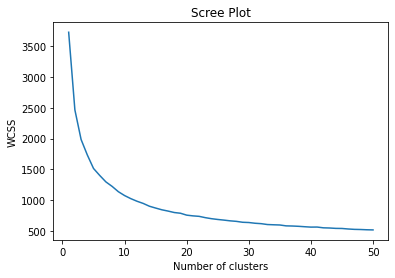

In [36]:
kmeans_data = all_data.drop(['Family', 'Genus', 'Species', 'RecordID', 'Family_code', 'Genus_code', 'Species_code'], axis=1)
wcss=[]

for i in range(1,51):
    kmeans = KMeans(i)
    kmeans.fit(kmeans_data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
number_clusters = range(1,51)
plt.plot(number_clusters,wcss)
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

##### Reference: https://github.com/milesgranger/gap_statistic

In [37]:
optimalK = OptimalK(parallel_backend='rust')
n_clusters = optimalK(kmeans_data, cluster_array=[x for x in range(1,51)])

In [38]:
best_k = n_clusters

In [3]:
print(f"The Best K determined using the Gap Statistic is {best_k}.")

The Best K determined using the Gap Statistic is 29.


#### 2. b)

In [40]:
data_with_clusters = kmeans_data.copy()
kmeans = KMeans(best_k)
kmeans.fit(kmeans_data)
identified_clusters = kmeans.fit_predict(kmeans_data)
data_with_clusters['Clusters'] = identified_clusters 
data_with_clusters['Family'] = all_data['Family']
data_with_clusters['Genus'] = all_data['Genus']
data_with_clusters['Species'] = all_data['Species']

In [41]:
cluster_data = {}
for k in range(best_k):
    families = {}
    for item in data_with_clusters.Family.unique():
        families[item] = 0
    genus = {}
    for item in data_with_clusters.Genus.unique():
        genus[item] = 0
    species = {}
    for item in data_with_clusters.Species.unique():
        species[item] = 0
    cluster_data[str(k)] = {}
    cluster_data[str(k)]['family'] = families
    cluster_data[str(k)]['genus'] = genus
    cluster_data[str(k)]['species'] = species

In [42]:
for index, row in data_with_clusters.iterrows():
    cluster_data[str(row['Clusters'])]['family'][row['Family']] += 1
    cluster_data[str(row['Clusters'])]['genus'][row['Genus']] += 1
    cluster_data[str(row['Clusters'])]['species'][row['Species']] += 1

In [43]:
max_data = {}
for cluster in cluster_data.keys():
    max_data[cluster] = {}
    for column in cluster_data[cluster].keys():
        max_data[cluster][column] = max(cluster_data[cluster][column], key=cluster_data[cluster][column].get)

In [44]:
summary_data = {
                'Cluster':  list(map(lambda x: int(x)+1, max_data.keys())),
                'Majority Family': list(map(lambda x: max_data[x]['family'], max_data.keys())),
                'Majority Genus': list(map(lambda x: max_data[x]['genus'], max_data.keys())),
                'Majority Species': list(map(lambda x: max_data[x]['species'], max_data.keys()))
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Cluster')

,Majority Family,Majority Genus,Majority Species
Cluster,,,
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Dendrobatidae,Ameerega,Ameeregatrivittata
3,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
4,Hylidae,Hypsiboas,HypsiboasCordobae
5,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
6,Dendrobatidae,Ameerega,Ameeregatrivittata
7,Hylidae,Hypsiboas,HypsiboasCinerascens
8,Hylidae,Hypsiboas,HypsiboasCordobae
9,Leptodactylidae,Adenomera,AdenomeraAndre


#### 2 c)

In [45]:
wrong_labels = 0
all_labels = data_with_clusters.shape[0]*3
correct_labels = all_labels
hamming_distances = []
for index, row in data_with_clusters.iterrows():
    row_ham = 0
    if(row['Family']!=max_data[str(row['Clusters'])]['family']):
        wrong_labels += 1
        correct_labels -= 1
        row_ham += 1
    if(row['Genus']!=max_data[str(row['Clusters'])]['genus']):
        wrong_labels += 1
        correct_labels -= 1
        row_ham += 1
    if(row['Species']!=max_data[str(row['Clusters'])]['species']):
        wrong_labels += 1
        correct_labels -= 1
        row_ham += 1
    hamming_distances.append(row_ham)
hamming_loss = wrong_labels/all_labels 
hamming_score = correct_labels/all_labels 
avg_hamming_distance = sum(hamming_distances) / len(hamming_distances)

In [46]:
summary_data = {
                'Parameter':  ['Average Hamming Distance', 'Hamming Score', 'Hamming Loss'],
                'Values': [avg_hamming_distance, hamming_score, hamming_loss]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameter')

,Values
Parameter,
Average Hamming Distance,0.164698
Hamming Score,0.945101
Hamming Loss,0.054899


#### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set (With Monte-Carlo Simulations)

In [47]:
def MonteCarlo():
    kmeans_data = all_data.drop(['Family', 'Genus', 'Species', 'RecordID', 'Family_code', 'Genus_code', 'Species_code'], axis=1)
    
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(kmeans_data, cluster_array=[x for x in range(1,51)])
    
    best_k = n_clusters

    data_with_clusters = kmeans_data.copy()
    kmeans = KMeans(best_k)
    kmeans.fit(kmeans_data)
    identified_clusters = kmeans.fit_predict(kmeans_data)
    data_with_clusters['Clusters'] = identified_clusters 
    data_with_clusters['Family'] = all_data['Family']
    data_with_clusters['Genus'] = all_data['Genus']
    data_with_clusters['Species'] = all_data['Species']

    cluster_data = {}
    for k in range(best_k):
        families = {}
        for item in data_with_clusters.Family.unique():
            families[item] = 0
        genus = {}
        for item in data_with_clusters.Genus.unique():
            genus[item] = 0
        species = {}
        for item in data_with_clusters.Species.unique():
            species[item] = 0
        cluster_data[str(k)] = {}
        cluster_data[str(k)]['family'] = families
        cluster_data[str(k)]['genus'] = genus
        cluster_data[str(k)]['species'] = species

    for index, row in data_with_clusters.iterrows():
        cluster_data[str(row['Clusters'])]['family'][row['Family']] += 1
        cluster_data[str(row['Clusters'])]['genus'][row['Genus']] += 1
        cluster_data[str(row['Clusters'])]['species'][row['Species']] += 1

    max_data = {}
    for cluster in cluster_data.keys():
        max_data[cluster] = {}
        for column in cluster_data[cluster].keys():
            max_data[cluster][column] = max(cluster_data[cluster][column], key=cluster_data[cluster][column].get)

    wrong_labels = 0
    all_labels = data_with_clusters.shape[0]*3
    correct_labels = all_labels
    hamming_distances = []
    for index, row in data_with_clusters.iterrows():
        row_ham = 0
        if(row['Family']!=max_data[str(row['Clusters'])]['family']):
            wrong_labels += 1
            correct_labels -= 1
            row_ham += 1
        if(row['Genus']!=max_data[str(row['Clusters'])]['genus']):
            wrong_labels += 1
            correct_labels -= 1
            row_ham += 1
        if(row['Species']!=max_data[str(row['Clusters'])]['species']):
            wrong_labels += 1
            correct_labels -= 1
            row_ham += 1
        hamming_distances.append(row_ham)
    hamming_loss = wrong_labels/all_labels 
    hamming_score = correct_labels/all_labels 
    avg_hamming_distance = sum(hamming_distances) / len(hamming_distances)

    return [hamming_loss, hamming_score, avg_hamming_distance]

In [48]:
hamming_losses = []
hamming_scores = []
avg_hamming_distances = []
for i in range(50):
    temp = MonteCarlo()
    hamming_losses.append(temp[0])
    hamming_scores.append(temp[1])
    avg_hamming_distances.append(temp[2])

summary_data = {
                'Parameter':  ['Average Hamming Distance', 'Standard Deviation of Average Hamming Distance', 'Average Hamming Score', 'Standard Deviation of Hamming Score', 'Average Hamming Loss', 'Standard Deviation of Hamming Loss'],
                'Values': [np.mean(avg_hamming_distances), np.std(avg_hamming_distances), np.mean(hamming_scores), np.std(hamming_scores), np.mean(hamming_losses), np.std(hamming_losses)]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameter')

,Values
Parameter,
Average Hamming Distance,0.146482
Standard Deviation of Average Hamming Distance,0.014676
Average Hamming Score,0.951173
Standard Deviation of Hamming Score,0.004892
Average Hamming Loss,0.048827
Standard Deviation of Hamming Loss,0.004892


#### 3. ISLR 12.6.2

In [58]:
IFrame("./q3.pdf", width=900, height=800)